In [1]:
import pandas_datareader.data as web
import pandas as pd
import datetime as dt
import numpy as np
from sklearn.linear_model import LinearRegression
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
#Number of simulations
num_simulations = 1000
#Number of years
num_years = 5

# Import data & create dataframe

In this exercise two datasets will be used. The first one includes historic revenue growth, GDP growth and inflation while the second includes five-year forecasts for GDP growth and inflation. The historic figures where extracted from Fever-Tree annual accounts and the office of national statistics while the forecasted from the September 2020 PWC UK Economic Update.

In [3]:
#read historic data
df = pd.read_csv('data.csv',header=None)
df.columns=['revenue','%gdp_growth','%inflation']
#read forecasted data
df_fct = pd.read_csv('data_fct.csv',header=None)
df_fct.columns=['%gdp_growth_fct_vs','%inflation_fct_vs','%gdp_growth_fct_ls','%inflation_fct_ls']

In [4]:
df

,revenue,%gdp_growth,%inflation
0,0.097304,0.015,0.018
1,0.395067,0.013,0.025
2,0.664476,0.019,0.027
3,0.725461,0.019,0.007
4,0.707993,0.024,0.004
5,0.488756,0.026,0.015
6,0.438395,0.021,0.026
7,0.350000,0.015,0.028
8,0.791045,0.015,0.045


In [5]:
df_fct

,%gdp_growth_fct_vs,%inflation_fct_vs,%gdp_growth_fct_ls,%inflation_fct_ls
0,0.018,0.0162,0.018,0.0162
1,0.018,0.0162,0.018,0.0162
2,0.018,0.0162,0.018,0.0162
3,0.101,0.0150,0.039,0.0120
4,-0.111,0.0050,-0.120,0.0050


# Linkage between GDP & inflation, and the revenue growth of Fevertree

A linear relationship is assumed between revenue growth, GDP growth & inflation. Revenue is the dependent variable while GDP growth and inflation are the independent variables.

Multiple linear regression is used to calculate the two coefficients (b1, b2) along and the intercept (b0).

$ y =b ₀+b ₁x ₁+b₂x₂+c$  

Where y is the revenue growth, b0 the intercept, b1 the coefficient for GDP growth and b2 the coefficient for inflation. After calculating the coefficients and the intercept the equation above becomes:

$revenue Growth = 24.92*gdp Growth + 5.62*inflation - 0.06$

In [6]:
# create linear regression object
mlr = LinearRegression()

In [7]:
# fit linear regression
mlr.fit(df[['%gdp_growth', '%inflation']], df['revenue'])

LinearRegression()

In [8]:
intercept = mlr.intercept_
coefficients = mlr.coef_
gdp_coef = coefficients[0]
inf_coef = coefficients[1]

# Functions

In [9]:
def monteCarloDataframe(num_simulations,num_years,gdp_mean,gdp_std,inf_mean,inf_std,gdp_coef,inf_coef,last_revenue,ebitda_pct):
    '''Performs the monte carlo simulation and returns a dataframe'''
    simulation_df = pd.DataFrame()
    for x in range(num_simulations):
        count = 0

        ebitda_series = []
        revenue_series = []
        gdp_growth = np.random.normal(loc = gdp_mean, scale = gdp_std)
        inflation = np.random.normal(loc = inf_mean, scale = inf_std)
        revenue_growth = gdp_coef*gdp_growth + inf_coef*inflation
        revenue = last_revenue*(1+revenue_growth)
        revenue_series.append(revenue)
        ebitda = revenue*ebitda_pct
        ebitda_series.append(ebitda)

        for y in range(num_years):
            if count==num_years-1:
                break
            gdp_growth = np.random.normal(loc = gdp_mean, scale = gdp_std)
            inflation = np.random.normal(loc = inf_mean, scale = inf_std)
            revenue_growth = gdp_coef*gdp_growth + inf_coef*inflation
            revenue = revenue_series[count]*(1+revenue_growth)
            revenue_series.append(revenue)
            ebitda = revenue*ebitda_pct
            ebitda_series.append(ebitda)
            count+=1
        simulation_df[x] = ebitda_series
        
    return simulation_df

In [10]:
def createPlot(simulation_df):
    ''' Creates a plot'''
    fig = plt.figure()
    fig.suptitle('Monte Carlo Simulation Fever-Tree')
    plt.plot(simulation_df)
    plt.axhline(y=last_ebitda,color='r',linestyle='-')
    plt.xlabel('Years')
    plt.ylabel('EBITDA')
    plt.show()

# Scenario_1 - Covid didn't Happen

The first scenario assumes that covid did not occur and as a result there is no major fluctuations in UK economy. The following assumptions are used:

* GDP Growth follows a normal distribution with mean equal to 1.8% and a standard deviation equal to 0.44% (based on past 9 years GDP growth). 
* Inflation follows a normal distribution with mean 2.1% and standard deviation of 1.2% (based on inflation of the past 9 years)
* EBITDA as a percentage of revenues is always the same and equal to 31.52% (average EBITDA of fever-tree the last 7 years)
* Inflation and GDP are independent variables e.g. changes in inflation does not affect GDP and vice versa.

In [11]:
# standard deviation of gdp growth and inflation
gdp_std = df['%gdp_growth'].std()
inf_std = df['%inflation'].std()
#mean of gdp and inflation
gdp_mean = df['%gdp_growth'].mean()
inf_mean = df['%inflation'].mean()
#last reported revenue in millions 
last_revenue  = 260.5
#EBITDA as % of revenue
ebitda_pct = 0.3152
#last EBITDA
last_ebitda = 77.00

In [12]:
simulation_df_sc1 = monteCarloDataframe(num_simulations,num_years,gdp_mean,gdp_std,inf_mean,inf_std,gdp_coef,inf_coef,last_revenue,ebitda_pct)

In [13]:
# 5 years projection(rows) 1000 simulations (columns)
simulation_df_sc1

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,117.717188,143.097231,118.235744,135.135318,126.194550,137.047296,126.018377,127.739134,116.292059,126.468808,...,113.505502,130.594946,126.474580,127.829901,121.897078,112.261558,118.412699,106.265099,125.332175,143.117538
1,191.205409,232.773777,184.246566,222.152707,175.887488,216.210677,209.281886,196.867546,173.788842,173.857693,...,194.846142,220.941606,208.312597,206.483544,196.920324,203.391493,217.052642,144.492380,219.135688,209.172213
2,318.054871,370.861820,272.056628,381.977537,269.432387,356.592570,315.845482,307.368852,303.171993,278.388478,...,309.262588,331.720245,327.165183,304.462896,291.207946,355.862576,338.939618,201.832870,329.852074,286.492162
3,461.384259,499.917636,436.869029,698.482149,442.326093,513.023542,457.325287,585.188212,514.507164,457.588536,...,471.690602,535.676805,483.823521,503.556074,465.852431,506.526846,560.859911,330.044026,569.994892,482.679264
4,671.437502,737.822936,606.225424,1207.070234,668.912050,839.671711,714.397653,752.351423,730.858196,802.528022,...,605.466136,710.799452,736.611305,709.557749,788.795134,759.214509,916.934556,532.087600,882.445977,893.082930


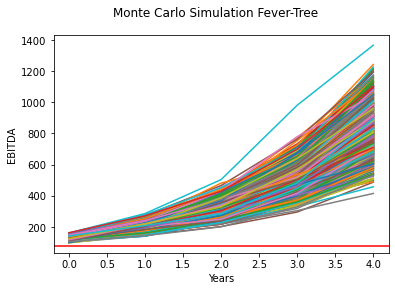

In [14]:
createPlot(simulation_df_sc1)

# Scenario_2 - Covid did Happen - VShaped Recession

The second scenario assumes a major recession in UK economy in 2020, a sharp recovery in 2021 and steady growth thereafter. The GDP growth and inflation forecasts for 2020 and 2021 were obtained from the September PWC UK Economic Update. The GDP growth and inflation for 2022, 2023 and 2024 is assumed to be equal to the average of the last 5 years which signals a return to normality in the medium to long term. The following assumption are used:

* GDP Growth follows a normal distribution with mean equal to 0.8% and a standard deviation equal to 7.6% (based on 5 years forecasted Vshaped GDP growth). 
* Inflation follows a normal distribution with mean 1.3% and standard deviation of 0.4% (based on 5 years forecasted Vshaped inflation).
* EBITDA as a percentage of revenues is always the same and equal to 31.52% (average EBITDA of fever-tree the last 7 years).
* Inflation and GDP are independent variables e.g. changes in inflation does not affect GDP and vice versa.

In [15]:
# standard deviation of gdp growth and inflation
gdp_std = df_fct['%gdp_growth_fct_vs'].std()
inf_std = df_fct['%inflation_fct_vs'].std()
#mean of gdp and inflation
gdp_mean = df_fct['%gdp_growth_fct_vs'].mean()
inf_mean = df_fct['%inflation_fct_vs'].mean()
#last reported revenue in millions 
last_revenue  = 260.5
#EBITDA as % of revenue
ebitda_pct = 0.3152
#last EBITDA
last_ebitda = 77.00

In [16]:
simulation_df_sc2 = monteCarloDataframe(num_simulations,num_years,gdp_mean,gdp_std,inf_mean,inf_std,gdp_coef,inf_coef,last_revenue,ebitda_pct)

In [17]:
# 5 years projection(rows) 1000 simulations (columns)
simulation_df_sc2

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,119.842314,193.763807,225.815567,84.168244,-112.388368,71.475792,179.151804,-155.485294,-21.290015,197.512141,...,102.274774,272.299963,-72.846208,266.608455,-4.253919,34.141393,191.596885,-228.768825,76.700071,-180.613942
1,154.787662,106.703927,590.719533,276.969930,11.731892,308.035779,797.844144,-391.748628,103.708820,49.890990,...,111.043373,103.875346,-42.773479,567.998824,-5.777904,54.087560,-386.486444,-120.843061,121.126304,169.620744
2,206.918436,13.501353,-835.444265,1279.726938,18.730268,189.464541,681.869449,-982.803244,-83.055805,157.307699,...,440.972865,169.929545,-58.385113,-831.787922,3.213974,91.790870,-217.668200,27.319641,-59.910976,-1.437612
3,1067.481999,3.273822,-1258.218329,-852.032645,39.436879,-647.505445,942.748536,-1362.685653,-143.451532,134.691477,...,1740.036000,523.064103,-47.583299,-1691.432317,13.490670,262.956702,450.930237,-22.465462,-42.109122,-1.212371
4,2044.435803,6.653562,-2767.804848,-765.847161,134.654732,-759.181107,-156.757965,752.775116,-165.681095,60.261999,...,-709.316776,1676.961067,-52.467355,152.144403,22.674559,470.475473,973.494969,-22.145109,-120.932149,-0.435498


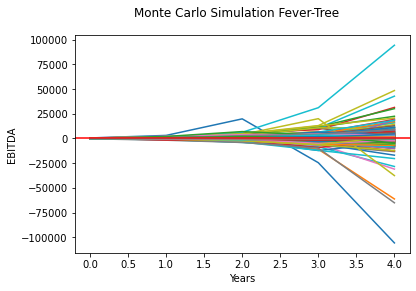

In [18]:
createPlot(simulation_df_sc2)

# Scenario_3 - Covid did Happen - LShaped Recession

The third scenario assumes a major recession in UK economy in 2020 and gradual recovery from 2021 onwards. The GDP growth and inflation forecasts for 2020 and 2021 were obtained from the September PWC UK Economic Update. I assumed a GDP growth and inflation for 2022, 2023 and 2024 will equal to the average of the last 5 years which signals a return to normality in the medium to long term. The following assumption are used:

* GDP Growth follows a normal distribution with mean equal to -0.53% and a standard deviation equal to 6.4% (based on 5 years forecasted Lshaped GDP growth). 
* Inflation follows a normal distribution with mean 1.3% and standard deviation of 0.48% (based on 5 years forecasted Lshaped inflation).
* EBITDA as a percentage of revenues is always the same and equal to 31.52% (average EBITDA of fever-tree the last 7 years).
* Inflation and GDP are independent variables e.g. changes in inflation does not affect GDP and vice versa.

In [19]:
# standard deviation of gdp growth and inflation
gdp_std = df_fct['%gdp_growth_fct_ls'].std()
inf_std = df_fct['%inflation_fct_ls'].std()
#mean of gdp and inflation
gdp_mean = df_fct['%gdp_growth_fct_ls'].mean()
inf_mean = df_fct['%inflation_fct_ls'].mean()
#last reported revenue in millions 
last_revenue  = 260.5
#EBITDA as % of revenue
ebitda_pct = 0.3152
#last EBITDA
last_ebitda = 77.00

In [20]:
inf_std

0.004889989775040435

In [21]:
simulation_df_sc3 = monteCarloDataframe(num_simulations,num_years,gdp_mean,gdp_std,inf_mean,inf_std,gdp_coef,inf_coef,last_revenue,ebitda_pct)

In [22]:
# 5 years projection(rows) 1000 simulations (columns)
simulation_df_sc3

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,55.319611,2.844270,-110.020151,-78.747477,206.381531,-37.053287,42.037727,75.533011,57.711221,211.429641,...,433.437548,-28.889286,85.604774,11.588011,84.310755,169.113141,120.436343,-99.690020,-66.182917,341.262103
1,26.456964,0.887934,-142.735821,-262.333597,283.163715,-3.886995,-64.326617,271.295492,-82.982896,-432.194843,...,1630.127937,-22.345722,-134.813091,25.050263,30.429038,398.091128,213.954254,-63.946940,39.992318,550.378562
2,53.284408,0.456029,-216.935493,164.419576,613.734759,-3.069705,-76.648971,-253.275824,-298.701420,-1304.932808,...,-399.024478,6.611069,-237.112286,-26.896170,-29.262058,246.367899,761.230137,-19.338808,-14.554527,354.392782
3,90.167440,-0.282235,-592.107566,-66.749487,-351.856512,-2.057497,15.862599,-53.496976,-86.909262,-2219.030559,...,-341.330618,5.890011,-217.202722,-22.699580,14.812773,319.055808,460.220294,-11.020503,28.862385,1136.115456
4,290.447776,0.124381,-1292.978062,85.148362,-851.967315,-0.895487,44.363353,-53.433030,-18.541135,-3919.094425,...,-437.775810,18.020331,-206.084156,-11.314000,-5.967222,180.030712,1273.714473,-17.387393,53.521585,-2000.614035


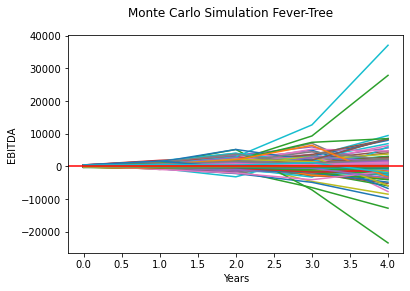

In [23]:
createPlot(simulation_df_sc3)

# Scenario_4 - Covid did Happen - LShaped Recession - Major Fixed costs

The forth scenario makes the same assumptions as scenario_3 in terms of gdp growth and inflation but this time it assumes that fever-tree has major fixed costs associated with cost of sales and as a result EBITDA as a % of sales is lower. The following assumption are used:

* GDP Growth follows a normal distribution with mean equal to -0.53% and a standard deviation equal to 6.4% (based on 5 years forecasted Lshaped GDP growth). 
* Inflation follows a normal distribution with mean 1.3% and standard deviation of 0.48% (based on 5 years forecasted Lshaped inflation)
* EBITDA as a percentage of revenues is always the same and equal to 20.00%.
* Inflation and GDP are independent variables e.g. changes in inflation does not affect GDP and vice versa.

In [24]:
# standard deviation of gdp growth and inflation
gdp_std = df_fct['%gdp_growth_fct_ls'].std()
inf_std = df_fct['%inflation_fct_ls'].std()
#mean of gdp and inflation
gdp_mean = df_fct['%gdp_growth_fct_ls'].mean()
inf_mean = df_fct['%inflation_fct_ls'].mean()
#last reported revenue in millions 
last_revenue  = 260.5
#EBITDA as % of revenue
ebitda_pct = 0.20
#last EBITDA
last_ebitda = 77.00

In [25]:
simulation_df_sc4 = monteCarloDataframe(num_simulations,num_years,gdp_mean,gdp_std,inf_mean,inf_std,gdp_coef,inf_coef,last_revenue,ebitda_pct)

In [26]:
# 5 years projection(rows) 1000 simulations (columns)
simulation_df_sc4

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-10.933048,63.566549,98.700661,161.673080,81.960490,47.212677,105.949407,34.994052,-68.938336,99.228186,...,179.387824,34.083536,-50.989054,-107.381149,104.429931,-43.636966,72.541674,-35.276799,110.136494,121.508340
1,19.677997,77.035215,38.288816,136.756906,155.060095,100.992944,164.886771,32.763403,-186.452904,59.103062,...,222.715550,68.563771,39.785948,247.259927,246.660774,-54.915368,100.632491,-42.411417,33.804502,84.010384
2,18.349561,119.246928,82.021814,209.342883,182.785877,561.405896,-192.811452,26.875476,-660.302833,29.047269,...,257.740392,122.744095,92.517667,553.774154,728.467780,-38.963969,127.293263,-85.139777,73.390845,-81.279243
3,-2.602086,265.161815,-18.417277,195.791998,148.459470,106.821980,-306.731599,43.390062,-1098.854358,68.803326,...,-29.649859,97.808771,-112.426598,-532.891118,1184.834048,-53.667028,352.400995,14.854697,93.241177,-188.539952
4,-3.093612,332.398634,-25.845798,208.276461,-17.619740,420.898600,-322.386508,-42.192936,175.710286,179.166992,...,-69.309021,-116.647992,-482.863407,-887.633716,1509.618944,33.295192,26.072958,26.737046,3.982985,256.517275


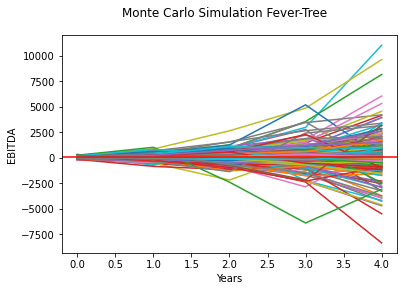

In [27]:
createPlot(simulation_df_sc4)

# Scenario_5 - Covid did Happen - VShaped Recession - Major Fixed costs

The forth scenario makes the same assumptions as scenario_2 in terms of gdp growth and inflation but this time it assumes that fever-tree has major fixed costs associated with cost of sales and as a result EBITDA as a % of sales is lower. The following assumption are used:

* GDP Growth follows a normal distribution with mean equal to 0.8% and a standard deviation equal to 7.6% (based on 5 years forecasted Vshaped GDP growth). 
* Inflation follows a normal distribution with mean 1.3% and standard deviation of 0.4% (based on 5 years forecasted Vshaped inflation)
* EBITDA as a percentage of revenues is always the same and equal to 20.00% (average EBITDA of fever-tree the last 7 years)
* Inflation and GDP are independent variables e.g. changes in inflation does not affect GDP and vice versa.

In [28]:
# standard deviation of gdp growth and inflation
gdp_std = df_fct['%gdp_growth_fct_vs'].std()
inf_std = df_fct['%inflation_fct_vs'].std()
#mean of gdp and inflation
gdp_mean = df_fct['%gdp_growth_fct_vs'].mean()
inf_mean = df_fct['%inflation_fct_vs'].mean()
#last reported revenue in millions 
last_revenue  = 260.5
#EBITDA as % of revenue
ebitda_pct = 0.20
#last EBITDA
last_ebitda = 77.00

In [29]:
simulation_df_sc5 = monteCarloDataframe(num_simulations,num_years,gdp_mean,gdp_std,inf_mean,inf_std,gdp_coef,inf_coef,last_revenue,ebitda_pct)

In [30]:
# 5 years projection(rows) 1000 simulations (columns)
simulation_df_sc5

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-45.613312,-1.503281,164.779159,-167.141263,109.715746,24.565780,-138.694047,141.208228,98.417962,24.373770,...,31.921887,75.972502,134.122304,70.484661,178.851817,-100.026292,205.256462,-5.240399,71.622838,-61.099827
1,-12.136556,-0.094867,-298.407770,-352.510547,340.149429,33.871866,-318.923496,-275.114868,32.045545,3.220868,...,228.479567,308.826914,95.583763,41.046806,126.943603,-40.982802,150.966472,-10.255534,199.057653,-76.936463
2,-31.303889,0.049256,478.904851,359.217782,374.237101,-98.282125,345.305681,443.269671,273.917025,10.929402,...,478.708233,-870.129230,-167.390687,188.844403,146.715552,-26.563606,-193.394023,1.865182,597.525006,102.493200
3,21.179904,0.137121,1186.566713,734.212027,679.397637,-217.991646,181.490072,319.657468,-118.095253,-2.338081,...,-203.659277,-3609.285265,-329.696290,820.906496,-311.335744,-6.431842,-656.727123,-2.395787,2172.751345,-98.083576
4,45.812119,0.475281,5981.558274,147.242040,553.202191,-817.601891,-35.641375,320.875869,-201.161882,0.016919,...,-542.549875,-7942.968633,-45.099455,1154.112662,378.563359,1.866372,-367.816987,-12.497328,6480.458399,-243.627282


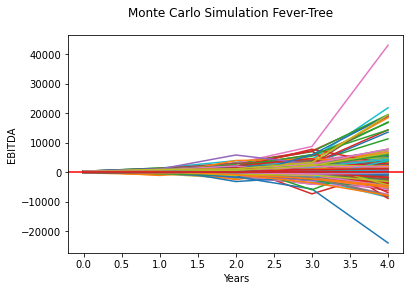

In [31]:
createPlot(simulation_df_sc5)

# Statistics

## Scenario_1  - Year 5

In [32]:
simulation_df_sc1_tr = simulation_df_sc1.transpose()
simulation_df_sc1_tr.columns = [2020,2021,2022,2023,2024]

<AxesSubplot:>

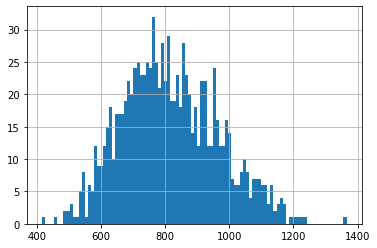

In [33]:
simulation_df_sc1_tr[2024].hist(bins=100)

In [34]:
simulation_df_sc1_tr[2024].describe()

count    1000.000000
mean      815.785856
std       149.315515
min       415.413556
25%       707.359037
50%       803.178275
75%       918.953936
max      1365.573883
Name: 2024, dtype: float64

## Scenario_2  - Year 5

In [35]:
simulation_df_sc2_tr = simulation_df_sc2.transpose()
simulation_df_sc2_tr.columns = [2020,2021,2022,2023,2024]

<AxesSubplot:>

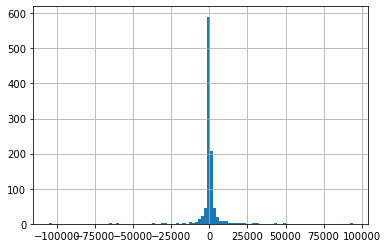

In [36]:
simulation_df_sc2_tr[2024].hist(bins=100)

In [37]:
simulation_df_sc2_tr[2024].describe()

count      1000.000000
mean        152.452953
std        6874.781328
min     -105726.962658
25%        -255.785340
50%           4.465199
75%         497.138354
max       94274.529013
Name: 2024, dtype: float64

## Scenario_3 - Year 5

In [38]:
simulation_df_sc3_tr = simulation_df_sc3.transpose()
simulation_df_sc3_tr.columns = [2020,2021,2022,2023,2024]

<AxesSubplot:>

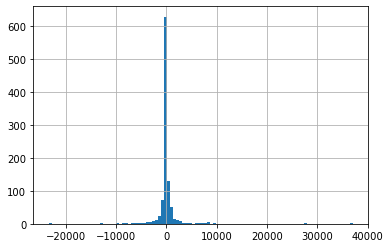

In [39]:
simulation_df_sc3_tr[2024].hist(bins=100)

In [40]:
simulation_df_sc3_tr[2024].describe()

count     1000.000000
mean        60.416849
std       2124.415462
min     -23431.577838
25%       -121.457977
50%          0.154684
75%        138.428309
max      37065.261804
Name: 2024, dtype: float64

## Scenario_4 - Year 5

In [41]:
simulation_df_sc4_tr = simulation_df_sc4.transpose()
simulation_df_sc4_tr.columns = [2020,2021,2022,2023,2024]

<AxesSubplot:>

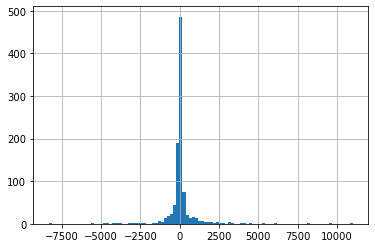

In [42]:
simulation_df_sc4_tr[2024].hist(bins=100)

In [43]:
simulation_df_sc4_tr[2024].describe()

count     1000.000000
mean        69.332979
std       1024.788417
min      -8335.303708
25%        -48.442991
50%          1.223766
75%         82.275759
max      11011.720335
Name: 2024, dtype: float64

## Scenario_5 - Year 5

In [44]:
simulation_df_sc5_tr = simulation_df_sc4.transpose()
simulation_df_sc5_tr.columns = [2020,2021,2022,2023,2024]

<AxesSubplot:>

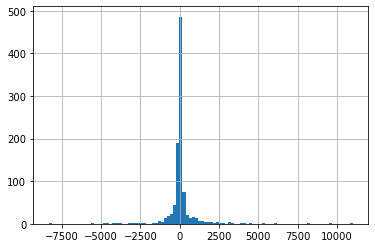

In [45]:
simulation_df_sc5_tr[2024].hist(bins=100)

In [46]:
simulation_df_sc5_tr[2024].describe()

count     1000.000000
mean        69.332979
std       1024.788417
min      -8335.303708
25%        -48.442991
50%          1.223766
75%         82.275759
max      11011.720335
Name: 2024, dtype: float64